# Решение задачи выбора локации новой скважины для добывающей компании

Нам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. 

Построим модель для определения региона, где добыча принесёт наибольшую прибыль. 

Проанализируем возможную прибыль и риски техникой Bootstrap.

## Содержание
- [Описание данных](#0)
1. [Загрузка и анализ данных](#1)    
2. [Построение моделей для регионов добычи](#2)    
3. [Расчет прибыли и оценка рисков возникновения убытков](#3)
- [Выводы](#6)

<a id="0"></a> 
## Описание данных
Данные геологоразведки трёх регионов находятся в файлах:
- geo_data_0.csv
- geo_data_1.csv
- geo_data_2.csv

где
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек;
- product — объём запасов в скважине (тыс. баррелей).

Условия:
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых выбирают 200 лучших для расчёта прибыли.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- Один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

<a id="1"></a> 
## Загрузка и анализ данных

In [ ]:
# импорт библиотек
import pandas as pd
import numpy as np

import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import scipy.stats as st

import warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:,.3f}'.format

In [ ]:
# загрузим данные
r0, r1, r2 = [pd.read_csv(
    f'/content/drive/My Drive/Datasets/geo_data_{i}.csv') for i in range(3)]

In [ ]:
# посмотрим на данные, для удобства выведем информацию по каждому региону горизонтально подряд
rs = [r0, r1, r2]
_0, _1, _2, _3 = [], [], [], []

for r in rs:
    r_info = pd.concat([r.dtypes, r.isna().count(), r.isna().sum()],
                       axis=1, keys=['dtypes', 'count', 'na_count']).reset_index()

    _0.append(r_info)
    _1.append(r.head())
    _2.append(r.describe())
    _3.append(r.corr())

for r in _0, _1, _2, _3:
    display(pd.concat(r, axis=1))

,index,dtypes,count,na_count,index,dtypes,count,na_count,index,dtypes,count,na_count
0,id,object,100000,0,id,object,100000,0,id,object,100000,0
1,f0,float64,100000,0,f0,float64,100000,0,f0,float64,100000,0
2,f1,float64,100000,0,f1,float64,100000,0,f1,float64,100000,0
3,f2,float64,100000,0,f2,float64,100000,0,f2,float64,100000,0
4,product,float64,100000,0,product,float64,100000,0,product,float64,100000,0


,id,f0,f1,f2,product,id,f0,f1,f2,product,id,f0,f1,f2,product
0,txEyH,0.706,-0.498,1.221,105.280,kBEdx,-15.001,-8.276,-0.006,3.179,fwXo0,-1.147,0.963,-0.829,27.759
1,2acmU,1.335,-0.340,4.365,73.038,62mP7,14.272,-3.475,0.999,26.953,WJtFt,0.263,0.270,-2.530,56.070
2,409Wp,1.023,0.152,1.420,85.266,vyE1P,6.263,-5.948,5.001,134.766,ovLUW,0.195,0.289,-5.586,62.872
3,iJLyR,-0.032,0.139,2.979,168.621,KcrkZ,-13.081,-11.506,4.999,137.945,q6cA6,2.236,-0.554,0.930,114.573
4,Xdl7t,1.988,0.155,4.752,154.037,AHL4O,12.702,-8.147,5.004,134.766,WPMUX,-0.516,1.716,5.899,149.601


,f0,f1,f2,product,f0,f1,f2,product,f0,f1,f2,product
count,"100,000.000","100,000.000","100,000.000","100,000.000","100,000.000","100,000.000","100,000.000","100,000.000","100,000.000","100,000.000","100,000.000","100,000.000"
mean,0.500,0.250,2.503,92.500,1.141,-4.797,2.495,68.825,0.002,-0.002,2.495,95.000
std,0.872,0.504,3.248,44.289,8.966,5.120,1.704,45.944,1.732,1.730,3.473,44.750
min,-1.409,-0.848,-12.088,0.000,-31.610,-26.359,-0.018,0.000,-8.760,-7.084,-11.970,0.000
25%,-0.073,-0.201,0.288,56.498,-6.299,-8.268,1.000,26.953,-1.162,-1.175,0.130,59.450
50%,0.502,0.250,2.516,91.850,1.153,-4.813,2.011,57.086,0.009,-0.009,2.484,94.926
75%,1.074,0.701,4.715,128.564,8.621,-1.333,4.000,107.813,1.159,1.164,4.859,130.595
max,2.362,1.344,16.004,185.364,29.422,18.734,5.020,137.945,7.238,7.845,16.739,190.030


,f0,f1,f2,product,f0,f1,f2,product,f0,f1,f2,product
f0,1.000,-0.441,-0.003,0.144,1.000,0.182,-0.002,-0.030,1.000,0.001,-0.000,-0.002
f1,-0.441,1.000,0.002,-0.192,0.182,1.000,-0.003,-0.010,0.001,1.000,0.001,-0.001
f2,-0.003,0.002,1.000,0.484,-0.002,-0.003,1.000,0.999,-0.000,0.001,1.000,0.446
product,0.144,-0.192,0.484,1.000,-0.030,-0.010,0.999,1.000,-0.002,-0.001,0.446,1.000


Посмотрим, как распределены данные.

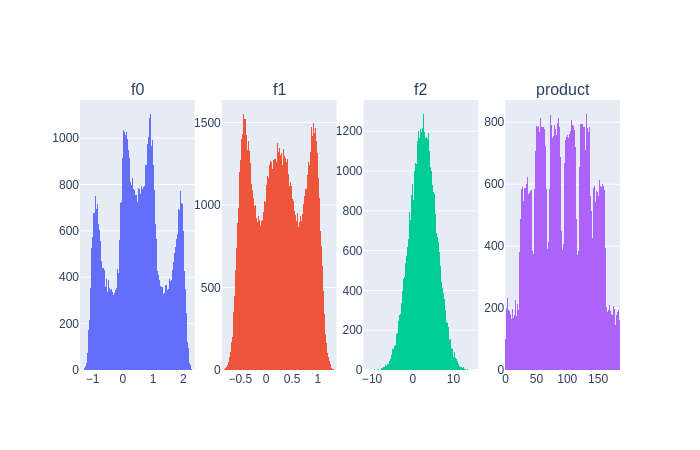

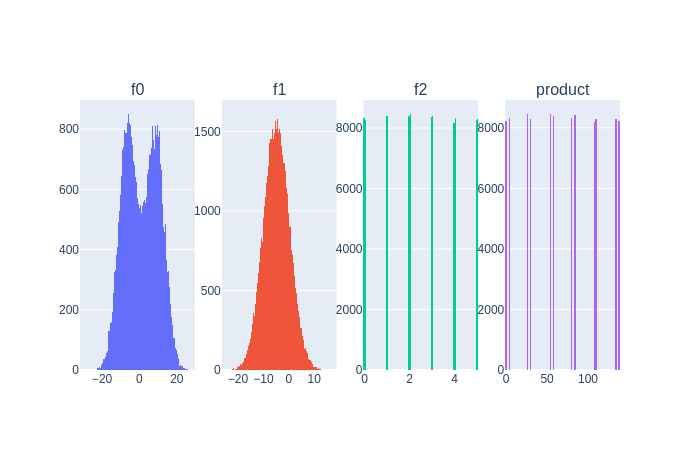

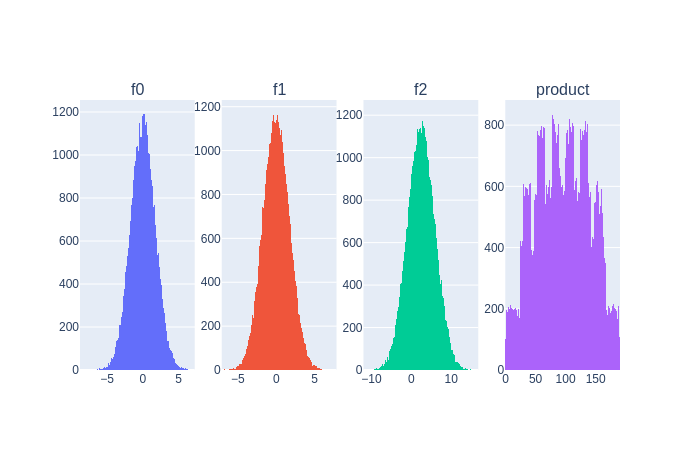

In [ ]:
for r in rs:
    fig = make_subplots(rows=1, cols=len(r.columns[1:]), subplot_titles=r.columns[1:])
    i = 1
    for feature in r.columns[1:]:
        fig.add_trace(go.Histogram(x=r[feature]), row=1, col=i)
        fig.update_layout(height=350, showlegend=False)        
        i += 1
    fig.show('png')

Мы видим, что в целом данные готовы к работе. Пропусков нет, типы данных корректны.  

Очевидно , что значения id не представляют для нас ценности, поэтому не будем учитывать их в дальнейшем при формировании выборок.

Данные в основном распределены нормально. При этом обратим внимание на то, как выделяется второй регион (r1). Мы видим всего 12 уникальных значений целевого признака и его почти полную корреляцию с признаком f2.



<a id="2"></a> 
## 2. Построение моделей для регионов добычи

Разобъем данные на обучающую и валидационную выборки в соотношении 3:1.  

In [ ]:
X_train, X_valid, y_train, y_valid = [], [], [], []
for r in rs:
    a, b, c, d = train_test_split(r.iloc[:, 1:-1], 
                                  r.iloc[:, -1], 
                                  test_size=.25, 
                                  random_state=0
                                  )
    X_train.append(a) 
    X_valid.append(b) 
    y_train.append(c) 
    y_valid.append(d) 

Обучим модель и сделаем предсказания на валидационной выборке. Сохраним все предсказания в Series `predicted_valid`

In [ ]:
lr = LinearRegression()
predicted_valid = []
for i in range(3):
    lr.fit(X_train[i], y_train[i])
    predicted_valid.append(pd.Series(lr.predict(X_valid[i]), 
                                     index=y_valid[i].index))

Оценим результаты на валидационной выборке.

In [ ]:
_ = []
for i in range(3):
    rmse = mean_squared_error(y_valid[i], predicted_valid[i]) ** 0.5
    _.append([y_valid[i].mean(), predicted_valid[i].mean(), rmse])
mean_values = pd.DataFrame(_, columns=['y_valid_mean', 'predicted_valid_mean', 'rmse'])   
mean_values

,y_valid_mean,predicted_valid_mean,rmse
0,92.467,92.271,37.481
1,69.154,69.152,0.887
2,95.471,94.708,40.313


Сравним фактические и предсказанные значения на графиках.

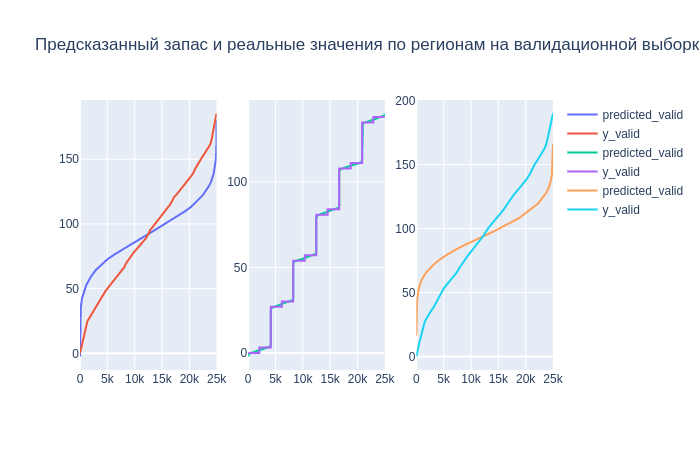

In [ ]:
fig = make_subplots(rows=1, cols=3)
i = 1
for r in range(3):
    fig.add_trace(go.Scatter(y=sorted(predicted_valid[r]), 
                             name='predicted_valid'), row=1, col=i)
    fig.add_trace(go.Scatter(y=sorted(y_valid[r]), 
                             name='y_valid'), row=1, col=i)
    fig.update_layout(title='Предсказанный запас и реальные значения по регионам на валидационной выборке')
    i += 1
fig.show('png')

Мы можем наблюдать наилучшие результаты предсказаний по региону r1, что было ожидаемо с учетом сильной корреляции целевой переменной с одним из признаков.  
Заметим также, что в двух остальных регионах модели предсказывают завышенные значения в области ниже среднего и наоборот.

<a id="3"></a> 
## 3. Расчет прибыли и оценка рисков возникновения убытков

Сохраним ключевые значения для расчетов.  

In [ ]:
POINTS = 500          # количество точек, исследуемых при разведке региона 
BEST_POINTS = 200     # количество лучших точек, выбираемых для расчёта прибыли
BUDGET = 10_000_000   # бюджет на разработку скважин в регионе, тыс. руб.
UNIT_REVENUE = 450    # доход с каждой единицы продукта (с каждой тыc. барр.), тыс. руб.
LOSS_PROB = .025      # критическое значение вероятности убытков (регионы с бОльшим значением удаляются из рассмотрения)

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. 

In [ ]:
bep = BUDGET / UNIT_REVENUE / BEST_POINTS

Сравним полученный объём сырья со средним запасом в каждом регионе.

In [ ]:
mean_values['BEP'] = bep
mean_values.iloc[:, [0, -1]]

,y_valid_mean,BEP
0,92.467,111.111
1,69.154,111.111
2,95.471,111.111


Очевидно, что средние значения запасов сырья меньше значений безубыточности.     При этом обратим внимание, что при расчете прибыли в новом регионе мы оприаемся только на 200 лучших точек из 500 исследуемых. Рассчитаем средние значения для лучших 200 точек в выборке.

In [ ]:
mean_values['best_points_mean'] = [(y_valid[i]
                                    .sort_values()[-BEST_POINTS:]
                                    .mean()) for i in range(3)]
mean_values.iloc[:, [0, -1, -2]]

,y_valid_mean,best_points_mean,BEP
0,92.467,183.445,111.111
1,69.154,137.945,111.111
2,95.471,187.933,111.111


В данном случае мы наблюдаем обратную картину во всех регионах.

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели.

In [ ]:
def profit(target, prediction, n_wells):
    wells_max = target[prediction.sort_values().index][-n_wells:]   # скважины с максимальными значениями предсказаний
    amount = wells_max.sum()
    profit = UNIT_REVENUE * amount - BUDGET
    return profit

Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.  
 Сохраним полученные распределения по каждому региону в списке `prof_dist`.

In [ ]:
state = np.random.RandomState(0)

prof_dist = []
for i in range(3):    
    values = []
    for j in range(1000):
        y_subsample = y_valid[i].sample(n=POINTS, replace=True, random_state=state) 
        pred_subsample = predicted_valid[i][y_subsample.index]
        prof = profit(y_subsample, pred_subsample, BEST_POINTS)
        values.append(prof)

    values = pd.Series(values)
    prof_dist.append(values)

Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков.

In [ ]:
def conf_int(sample):
    return st.t.interval(alpha=.95, df=len(sample)-1, 
                         loc=sample.mean(), scale=sample.sem()) 


res = pd.DataFrame(({'lower': conf_int(prof_dist[i])[0],                        # нижняя граница доверительного интервала
                     'upper': conf_int(prof_dist[i])[1],                        # верхняя граница доверительного интервала
                     'mean': prof_dist[i].mean(),                               # среднее значение 
                     'loss_prob': (prof_dist[i] < 0).sum() / len(prof_dist[i])  # вероятность убытков
                     } for i in range(3)),                                      # по каждому региону
                     index=['r0', 'r1', 'r2'])

res['pass'] = res.loss_prob < LOSS_PROB                                         # проходит ли значение отбор по допустимой вероятности убытков
res

,lower,upper,mean,loss_prob,pass
r0,"454,306.064","487,359.509","470,832.787",0.035,False
r1,"515,193.820","540,312.910","527,753.365",0.004,True
r2,"394,963.004","429,694.261","412,328.632",0.060,False


Визуализируем найденные распределения прибыли по каждому региону.

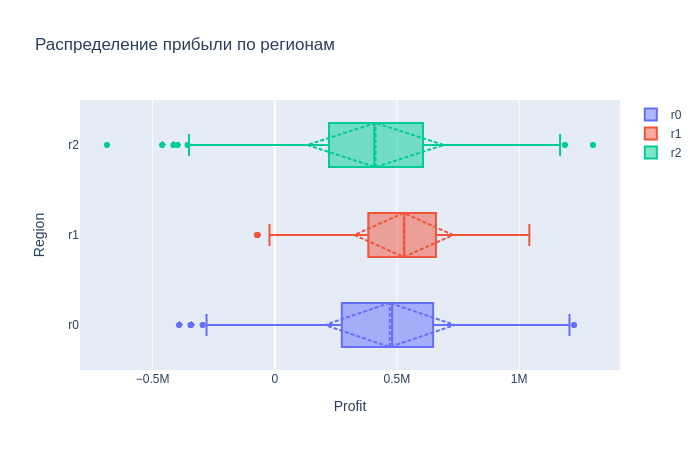

In [ ]:
fig = go.Figure()

for r in range(3):
    fig.add_trace(go.Box(x=prof_dist[r], name='r'+str(r), boxmean='sd')) 
    
fig.update_layout(title='Распределение прибыли по регионам', 
                  xaxis_title = 'Profit',
                  yaxis_title = 'Region')
fig.show('png')

Мы видим, что только регион r1 удовлетворяет требованию о вероятности убытков менее 2.5%. Он же показывает наибольшую среднюю прибыль.  
Таким образом, для разработки скважин мы предлагаем регион r1.

<a id="6"></a> 
## Выводы

В рамках настоящей работы мы проанализировали и обосновали выбор локации новой скважины для добывающей компании.

Мы построили модели и сделали предсказания добычи для каждого региона, рассчитали достаточный объём сырья для безубыточной разработки новой скважины и проанализировали полученные данные.

Для определения наиболее перспективного региона нами была проделана работа по оценке распределения прибыли с использованием бутстрепа, после чего мы смогли оценить значения средней прибыли в каждом регионе, 95%-й доверительный интервал и риск убытков.  

Базируясь на полученных данных мы увидели, что в регионе r1 вероятность убытков находится на уровне 0,4%, а средняя прибыль составляет почти 528 млн. руб., т.е. данный регион опережает остальные по каждому из ключевых показателей, что и определило наш выбор в пользу этого региона в качестве рекомендуемомго для разработки.